In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/Shared\ drives/ecl-pedro/video-coding-utils/notebooks/

AR-CNN-test.ipynb  __init__.py       utils.py          YUV_H264_YUV.sh
checkpoints/       requirements.yml  utils_test.ipynb  yuv_test.ipynb


In [1]:
from utils.utils import *
from utils import models

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# get kernel sizes from original Matlab implementation of AR-CNN
import scipy.io
mat = scipy.io.loadmat('../../papers/AR-CNN test code/code/model/q40.mat')

---
## Architecture definition
Example architecture based on ARCNN

In [6]:
ARCNN = Sequential([
    Conv2D(64, 9, activation='relu', padding='same', input_shape=(64,64,1), name='conv1'), # 64 9x9 filters, ReLU activation
    Conv2D(32, 7, activation='relu', padding='same', name='conv2'),                        # 32 7x7 filters, ReLU activation
    Conv2D(16, 1, activation='relu', padding='same', name='conv3'),                        # 16 1x1 filters, ReLU activation
    Conv2D(1, 5, activation=None, padding='same', name='conv4'),                           # 1  5x5 filter,    no activation
], name='AR-CNN')

# originally "replicate" padding

In [7]:
ARCNN.summary()

Model: "AR-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 64)        5248      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        100384    
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 16)        528       
_________________________________________________________________
conv4 (Conv2D)               (None, 64, 64, 1)         401       
Total params: 106,561
Trainable params: 106,561
Non-trainable params: 0
_________________________________________________________________


---
## Creation of the dataset

In [8]:
# x: compressed, y: ground truth
x_path = '../data/H264_raw/BasketballPass_416x240_50_H264_42.yuv'
y_path = '../data/YUV/BasketballPass_416x240_50.yuv'

In [9]:
height = int(y_path.split('_')[1].split('x')[1])
width = int(y_path.split('_')[1].split('x')[0])
size = (height, width)

In [10]:
# select frames
frames = range(0,256,2)
X = read_YUV420_multiframes(x_path, size, frames, channel='Y')
Y = read_YUV420_multiframes(y_path, size, frames, channel='Y')

In [11]:
X.shape, Y.shape

((128, 240, 416), (128, 240, 416))

In [12]:
# select random patches in those frames
N_patches_per_frame = 5
size_of_patches = (64,64)
idxs = n_random_slices(N_patches_per_frame, range(0,len(frames)), size, size_of_patches)

In [13]:
X = patches_from_idxs(X, idxs)
Y = patches_from_idxs(Y, idxs)

In [14]:
X = X.reshape(*X.shape, 1)
Y = Y.reshape(*Y.shape, 1)

In [15]:
# shapes: (examples, height, width, channels)
X.shape, Y.shape

((640, 64, 64, 1), (640, 64, 64, 1))

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [17]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((576, 64, 64, 1), (64, 64, 64, 1), (576, 64, 64, 1), (64, 64, 64, 1))

---
## Training

In [18]:
def PSNR(x,y):
    return tf.image.psnr(x,y,max_val=1)

ARCNN.compile(
    optimizer='SGD', # stochastic gradient descent (paper)
    loss=MSE, # mean squared error (paper)
    metrics=[PSNR]
)

Callback to save model weights at every epoch:

In [19]:
ckpt_callback = ModelCheckpoint(
    filepath='checkpoints/ARCNN',
    save_weights_only=True,
    verbose=0
)

In [20]:
history = ARCNN.fit(
    X_train, Y_train,
    batch_size=16, # (paper=128)
    epochs=5, # guess
    callbacks=[ckpt_callback],
    verbose=2
)

Epoch 1/5
36/36 - 23s - loss: 0.0729 - PSNR: 14.1288
Epoch 2/5
36/36 - 26s - loss: 0.0123 - PSNR: 19.2802
Epoch 3/5
36/36 - 28s - loss: 0.0117 - PSNR: 19.5466
Epoch 4/5
36/36 - 27s - loss: 0.0111 - PSNR: 19.7714
Epoch 5/5
36/36 - 31s - loss: 0.0106 - PSNR: 19.9776


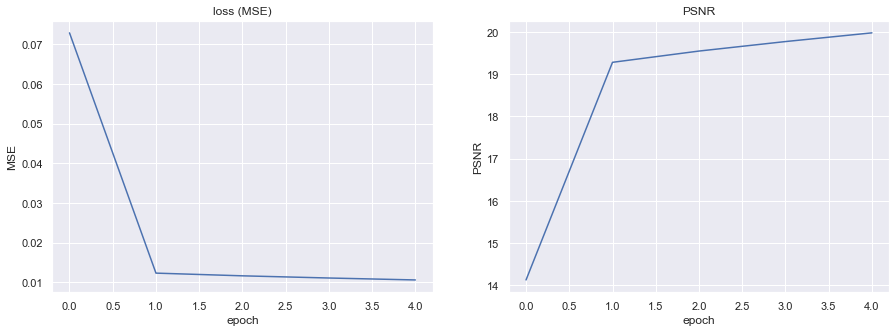

In [30]:
sns.set()
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(history.history['loss'])
ax[0].set_title('loss (MSE)')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('MSE')
ax[1].plot(history.history['PSNR'])
ax[1].set_title('PSNR')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('PSNR')
plt.show()

---
# Testing

In [22]:
Y_pred = ARCNN.predict(X_test)
results = ARCNN.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 85ms/step - loss: 0.0108 - PSNR: 19.8902


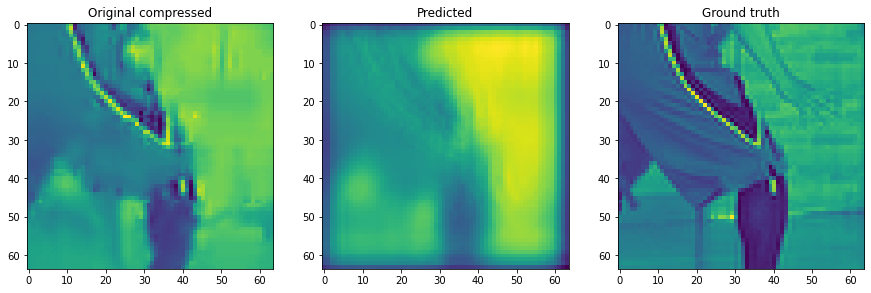

In [23]:
sns.reset_orig()
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(X_test[1,:,:,0])
ax[0].set_title('Original compressed')
ax[1].imshow(Y_pred[1,:,:,0])
ax[1].set_title('Predicted')
ax[2].imshow(Y_test[1,:,:,0])
ax[2].set_title('Ground truth')
plt.show()

---
## Loading saved weights

In [24]:
new_ARCNN = Sequential([
    Conv2D(64, 9, activation='relu', padding='same', input_shape=(64,64,1), name='conv1'), # 64 9x9 filters, ReLU activation
    Conv2D(32, 7, activation='relu', padding='same', name='conv2'),                        # 32 7x7 filters, ReLU activation
    Conv2D(16, 1, activation='relu', padding='same', name='conv3'),                        # 16 1x1 filters, ReLU activation
    Conv2D(1, 5, activation=None, padding='same', name='conv4'),                           # 1  5x5 filter,    no activation
], name='AR-CNN')

In [28]:
new_ARCNN.compile(
    optimizer='SGD', # stochastic gradient descent (paper)
    loss=MSE, # mean squared error (paper)
    metrics=[PSNR]
)
new_ARCNN.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 80ms/step - loss: 0.2231 - PSNR: 6.7020


[0.22308406233787537, 6.702037334442139]

In [29]:
new_ARCNN.load_weights('checkpoints/ARCNN')
new_ARCNN.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 85ms/step - loss: 0.0108 - PSNR: 19.8902


[0.010817071422934532, 19.89020538330078]